In [ ]:
#git clone https://github.com/lucidrains/iTransformer.git

In [1]:
# TODO which one?
#import iTransformer
import sys
sys.path.append('/vol/fob-vol7/nebenf21/reinbene/bene/MA/iTransformer') 
from iTransformer import iTransformer

import torch
import pandas as pd
from pathlib import Path
import holidays
import glob

import torch
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from utils.helpers import create_checkpoint, calc_percentiles
from config import *
from utils.data_handling import *
import numpy as np
from torch.utils.data import DataLoader

import pickle
import matplotlib.pyplot as plt
import random 



In [2]:
try:
    # Specify the file path where you want to save the dictionary
    file_path = '/vol/fob-vol7/nebenf21/reinbene/bene/MA/data/electricity/electricity_dict.pkl'

    # Load the dictionary from the file using pickle.load
    with open(file_path, 'rb') as file:
        data_dict = pickle.load(file)


except FileNotFoundError:
    data_dict = electricity_loader()

    for key, value in data_dict.items():
        data_dict[key] = df_to_tensor(value, standardize=True)
    # Save the dictionary to the file using pickle.dump
    with open(file_path, 'wb') as file:
        pickle.dump(data_dict, file)


train_tensor = data_dict["electricity_train"]
val_tensor = data_dict["electricity_val"]

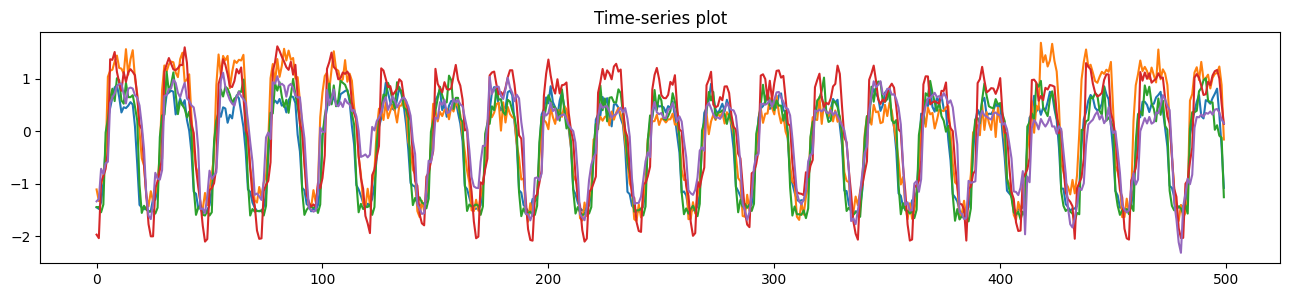

In [3]:
# sanity check if conversion worked correctly
# select 5 random time-series and 500 datapoints each
time_id = random.randint(0, train_tensor.size(0)-500)
ids = random.randint(0, train_tensor.size(1)-5)
numpy_array = train_tensor[time_id : time_id+500 , ids : ids+5].numpy()

# Plot the NumPy array using Matplotlib
plt.figure(figsize=(16, 3))
plt.plot(numpy_array)
plt.title("Time-series plot")
plt.show()

In [17]:
train_tensor = train_tensor[:, 0:10]
val_tensor = val_tensor[:, 0:10]

In [10]:
window_size = 96
pred_length = 96

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


train_window = SlidingWindowTimeSeriesDataset(train_tensor, window_size, pred_length)
val_window = SlidingWindowTimeSeriesDataset(val_tensor, window_size, pred_length)


train_dataloader = DataLoader(train_window, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_window, batch_size=32, shuffle=False)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Using device: cuda
Feature batch shape: torch.Size([32, 96, 348])
Labels batch shape: torch.Size([32, 96, 348])


In [13]:
config = {
    'num_variates': train_tensor.size(1),
    'lookback_len': window_size,
    'depth': 6,
    'dim': 512,
    'num_tokens_per_variate': 1,
    'pred_length': pred_length,
    'dim_head': 32,
    'heads': 4,
    'attn_dropout': 0.1,
    'ff_mult': 4,
    'ff_dropout': 0.1,
    'num_mem_tokens': 4,
    'use_reversible_instance_norm': True,
    'reversible_instance_norm_affine': False,
    'flash_attn': True
}

# defining all needed instances
model = iTransformer(**config).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
writer = SummaryWriter(log_dir="logs")#CONFIG_LOGS_PATH["series_standardized"])


In [14]:
epoch = 10

def train_one_epoch(epoch, model, device, train_dataloader, optimizer, scheduler, writer):
	global_step = 0
	model.train()
	total_loss = 0
	for input, target in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
		optimizer.zero_grad()
		input = input.to(device)
		target = target.to(device)
		#print(type(target), type(input))
		loss = model(input, target)
		
		#output = model(input) # create predictions
		#loss = torch.nn.MSELoss(reduction="mean")

		#loss = loss(output[model.pred_length[0]], target.to(device))  # compute loss on all variates
		
		loss.backward()
		optimizer.step()
		total_loss += loss.item()

		writer.add_scalar('train_loss', loss, global_step)
		writer.add_scalar('train_lr', optimizer.param_groups[0]['lr'], global_step)
		lr =  optimizer.param_groups[0]['lr']
		global_step+=1

	print(f'Epoch {epoch}, Loss: {total_loss / len(train_dataloader)}, LR: {lr}')

	scheduler.step()

	writer.close()
	if epoch % 5 == 0:
		create_checkpoint(model, optimizer, scheduler, epoch, loss, global_step, "iTransfomrer_electricity")

for epoch in range(1, epoch + 1):
	train_one_epoch(epoch, model, device, train_dataloader, optimizer, scheduler, writer)


Epoch: 1: 100%|██████████| 170/170 [00:22<00:00,  7.44it/s]


Epoch 1, Loss: 0.21660583404933706, LR: 0.001


Epoch: 2: 100%|██████████| 170/170 [00:23<00:00,  7.36it/s]


Epoch 2, Loss: 0.16781618586357902, LR: 0.001


Epoch: 3: 100%|██████████| 170/170 [00:22<00:00,  7.48it/s]


Epoch 3, Loss: 0.15724940212333904, LR: 0.001


Epoch: 4: 100%|██████████| 170/170 [00:23<00:00,  7.32it/s]


Epoch 4, Loss: 0.15121773376184353, LR: 0.001


Epoch: 5: 100%|██████████| 170/170 [00:23<00:00,  7.35it/s]


Epoch 5, Loss: 0.14494909784373114, LR: 0.001
Checkpointing succesfull after epoch 5


Epoch: 6: 100%|██████████| 170/170 [00:23<00:00,  7.34it/s]


Epoch 6, Loss: 0.12995684335336966, LR: 0.0001


Epoch: 7: 100%|██████████| 170/170 [00:23<00:00,  7.29it/s]


Epoch 7, Loss: 0.12383906801833826, LR: 0.0001


Epoch: 8: 100%|██████████| 170/170 [00:23<00:00,  7.16it/s]


Epoch 8, Loss: 0.12067931145429611, LR: 0.0001


Epoch: 9: 100%|██████████| 170/170 [00:24<00:00,  6.89it/s]


Epoch 9, Loss: 0.11817213231149842, LR: 0.0001


Epoch: 10: 100%|██████████| 170/170 [00:23<00:00,  7.16it/s]


Epoch 10, Loss: 0.11597076597459176, LR: 0.0001
Checkpointing succesfull after epoch 10


In [9]:
import numpy as np

def calc_percentiles(predictions, actuals, percentile):
	# take predictions, actuals in correct order and return percentiles
	# return p10, p50, p90
	
	errors = np.abs(predictions - actuals)

	# Sort the errors
	sorted_errors = np.sort(errors)

# Calculate p10, P50 and P90
	p_percentile = np.percentile(sorted_errors, percentile)
	return p_percentile

In [31]:
def eval_function(valid_dataloader):
	#model = iTransformer(**config)

	#checkpoint = torch.load("/vol/fob-vol7/nebenf21/reinbene/bene/MA/outputs/series_standardized/model_first_20_ids_full_epoch_10.pt")
	#model.load_state_dict(checkpoint['model_state_dict'])
	#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
	#start_epoch = checkpoint['epoch'] + 1  # Start training from 
	#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
	#scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
	#writer = SummaryWriter(log_dir='logs')
	#global_step = checkpoint['global_step_writer']

	#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
	#model.to(device)
	model.eval()
	global_step_eval = 1
	total_p10_eval = 0
	total_p50_eval = 0
	total_p90_eval = 0

	# Example inference code
	with torch.no_grad():
		total_loss_eval = 0
		for input, target in tqdm(valid_dataloader, desc=f"Epoch: Validating"):
			input = input.to(device)
			target = target.to(device)
			output = model(input)

			loss = torch.nn.MSELoss()
			loss = loss(output[96], target)  # compute loss on all variates
			#computed_loss = loss(output, target)  # compute loss on target variate

			total_loss_eval += loss.item()
			#total_p10_eval += calc_percentiles(output[12].cpu(), target.cpu(), 10)
			#total_p50_eval += calc_percentiles(output[12].cpu(), target.cpu(), 50)
			#total_p90_eval += calc_percentiles(output[12].cpu(), target.cpu(), 90)


	print(f'MSE Loss: {total_loss_eval / len(valid_dataloader)}')#\nP10: { total_p10_eval/ len(valid_dataloader)}\n\
	#P50: {total_p50_eval/ len(valid_dataloader)}\nP90: { total_p90_eval/ len(valid_dataloader)}')

	#writer.add_scalar('MSE/valid', total_loss_eval/ len(valid_dataloader), global_step_eval)
	#writer.add_scalar('P10/valid', total_p10_eval/ len(valid_dataloader), global_step_eval)
	#writer.add_scalar('P50/valid', total_p50_eval/ len(valid_dataloader), global_step_eval)
	#writer.add_scalar('P90/valid', total_p90_eval/ len(valid_dataloader), global_step_eval)

	writer.close()

In [22]:
eval_function(val_dataloader)

Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 27.98it/s]

MSE Loss: 0.1835039108991623


In [32]:
test_tensor = data_dict["electricity_test"]
test_window = SlidingWindowTimeSeriesDataset(test_tensor, window_size, pred_length)
test_dataloader = DataLoader(test_window, batch_size=32, shuffle=True)

eval_function(test_dataloader)

Epoch: Validating: 100%|██████████| 86/86 [00:04<00:00, 19.86it/s]

MSE Loss: 0.1695066345639007


In [30]:
len(val_dataloader)

1